# Summary

Testing tweaked PredictionExaminer version for Incendio. Removed fastai2 dependency. Pasted a couple incendio and htools functions here for convenience.

In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from htools import *
from img_wang.data import get_databunch
from img_wang.models import SingleInputBinaryModel, TorchvisionEncoder,\
    load_encoder
from img_wang.torch_utils import gpu_setup
from incendio.core import Trainer

In [8]:
cd_root()
gpu_setup()

Current directory: /storage/img-wang
Setting seeds for reproducible training.


In [28]:
def ifnone(arg, backup):
    """Shortcut to provide a backup value if an argument is None. Commonly used
    for numpy arrays since their truthiness is ambiguous.

    Parameters
    ----------
    arg: any
        We will check if this is None.
    backup: any
        This will be returned if arg is None.

    Returns
    -------
    Either `arg` or `backup` will be returned.
    """
    return arg if arg is not None else backup

In [29]:
def plot_images(images, titles=None, nrows=None, figsize=None, 
                tight_layout=True, title_colors=None):
    nrows = nrows or int(np.ceil(np.sqrt(len(images))))
    titles = ifnone(titles, [None] * len(images))
    colors = ifnone(title_colors, ['black'] * len(images))
    figsize = figsize or (nrows*2, nrows*2)
    fig, ax = plt.subplots(nrows, nrows, figsize=figsize)
    for axi, img, title, color in zip(ax.flatten(), images, titles, colors):
        axi.imshow(img.permute(1, 2, 0))
        axi.set_title(title, color=color)
        axi.set_axis_off()
    if tight_layout: plt.tight_layout()
    plt.show()

In [30]:
class PredictionExaminer:
    """Examine model predictions. This lets us view rows where the model was
    very confidently wrong, barely wrong, confidently right, barely right, or
    just random rows.
    """

    def __init__(self, trainer):
        self.trainer = trainer
        self.dls = {}
        self.dfs = {}

    def evaluate(self, split='val', return_df=True):
        dl = getattr(self.trainer, f'dl_{split}')
        if 'random' in type(dl.batch_sampler.sampler).__name__.lower():
            dl = DataLoader(dl.dataset, dl.batch_size, shuffle=False,
                            num_workers=dl.num_workers)
        self.dls[split] = dl
        _, y_proba, y_true = self.trainer.validate(dl, True, True,
                                                   logits=False)

        if self.trainer.mode == 'multiclass':
            y_proba, y_pred = y_proba.max(-1)
        else:
            y_pred = (y_proba > self.trainer.thresh).float()

        # Construct title strings.
        titles = [
            f'True: {y.item()}\nPred: {pred.item()} (p={proba.item():.3f})'
            for y, proba, pred in zip(y_true, y_proba, y_pred)
        ]
        df = pd.DataFrame(
            {'y': y_true.squeeze(-1).cpu().numpy(),
             'y_pred': y_pred.squeeze(-1).cpu().numpy(),
             'y_proba': y_proba.squeeze(-1).cpu().numpy(),
             'title': titles}
        )
        df['correct'] = (df.y == df.y_pred)
        df['color'] = np.where(df.correct, 'green', 'red')
        # Score of 1 means model was certain of correct answer.
        # Score of -1 means model was certain of incorrect answer.
        # By default, sort with biggest mistakes at top. Don't reset index.
        df['mistake'] = np.where(df.correct, -1, 1) * df.y_proba
        df.sort_values('mistake', ascending=False, inplace=True)
        self.dfs[split] = df
        if return_df: return df.drop('title', axis=1)

    @valuecheck
    def _select_base(self, mode='most_wrong', split='val', n=16,
                     pred_classes=None, true_classes=None, return_df=False):
        """Internal method that provides the functionality for all user-facing
        methods for filtering and displaying results.

        Parameters
        ----------
        mode: str
            One of ('most_wrong', 'least_wrong', 'most_correct',
            'least_correct', 'random'). "wrong/correct" refers to whether the
            predicted class matches the true class, while "most/least"
            considers the model's confidence as well. I.E. "most_wrong" means
            rows where the model predicted the wrong class with high
            confidence.
        n: int
            Number of images to display.
        pred_classes: Iterable[str] or None
            If provided, only show rows where the true label falls into these
            specific classes.
        true_classes: Iterable[str] or None
            If provided, only show rows where the predicted label falls into
            these specific classes.
        return_df: bool

        Returns
        -------
        pd.DataFrame or None: None by default, depends on `return_df`.
        """
        # Filter and sort rows based on desired classes and criteria.
        df, dl = self.dfs[split], self.dls[split]
        if pred_classes is not None:
            if isinstance(pred_classes, int): pred_classes = [pred_classes]
            df = df.loc[df.y_pred.isin(pred_classes)]
        if true_classes is not None:
            if isinstance(true_classes, int): true_classes = [true_classes]
            df = df.loc[df.y.isin(true_classes)]
        if mode == 'most_wrong':
            df = df[~df.correct].sort_values('mistake', ascending=False)
        elif mode == 'least_wrong':
            df = df[~df.correct].sort_values('mistake', ascending=True)
        elif mode == 'most_correct':
            df = df[df.correct].sort_values('mistake', ascending=True)
        elif mode == 'least_correct':
            df = df[df.correct].sort_values('mistake', ascending=False)
        elif mode == 'random':
            df = df.sample(frac=1, replace=False)
        if df.empty:
            warnings.warn('No examples meet that criteria.')
            return

        # Display images for selected rows.    
        idx = df.head(n).index.tolist()
        images = [torch.cat(dl.dataset[i][:-1], dim=-1) for i in idx]
        plot_images(images, titles=df.loc[idx, 'title'], 
                    title_colors=df.loc[idx, 'color'])
        if return_df: return df.dropna('title', axis=1)

    def most_wrong(self, split='val', n=16, pred_classes=None,
                   true_classes=None, return_df=False):
        return self._select_base('most_wrong', split, n, pred_classes,
                                 true_classes, return_df)

    def least_wrong(self, split='val', n=16, pred_classes=None,
                    true_classes=None, return_df=False):
        return self._select_base('least_wrong', split, n, pred_classes,
                                 true_classes, return_df)

    def most_correct(self, split='val', n=16, pred_classes=None,
                     true_classes=None, return_df=False):
        return self._select_base('most_correct', split, n, pred_classes,
                                 true_classes, return_df)

    def least_correct(self, split='val', n=16, pred_classes=None,
                      true_classes=None, return_df=False):
        return self._select_base('least_correct', split, n, pred_classes,
                                 true_classes, return_df)

    def random(self, split='val', n=16, pred_classes=None, true_classes=None,
               return_df=False):
        return self._select_base('random', split, n, pred_classes,
                                 true_classes, return_df)

    def class_to_top_mistakes(self, split='val', n=3):
        df = self.dfs[split]
        return {lbl: dict(df.loc[(~df.correct) & (df.y == lbl),
                                 'y_pred'].value_counts().head(n))
                for lbl in df.y.unique()}

    def confusion_matrix(self, split='val'):
        cm = pd.pivot_table(self.dfs[split], index='y', columns='y_pred',
                            values='title', aggfunc=len, fill_value=0)
        if len(set(cm.shape)) > 1 or not (cm.index == cm.columns).all():
            short_ax = np.argmin(cm.shape)
            cm = cm.reindex(cm.index.values if short_ax == 1
                            else cm.columns.values, axis=short_ax).fillna(0)
        return cm.style.background_gradient(axis=1)

    def label_vcounts(self, split='val', n=None):
        return self.dfs[split].y_pred.vcounts().head(n)

    def pred_vcounts(self, split='val', n=None):
        return self.dfs[split].y.vcounts().head(n)

In [11]:
dst, dsv, dlt, dlv = get_databunch('data/imagewang-160/', 
                                   mode='supervised',
                                   bs=256)

In [12]:
net = SingleInputBinaryModel(
    TorchvisionEncoder('mobilenet_v2', pretrained=False),
    n_out=len(dst.class_to_idx)
)

In [13]:
T = Trainer(net, dst, dsv, dlt, dlv, F.cross_entropy, 'multiclass', 
            'data/supervised_models/v10', last_act=nn.Softmax(-1))

## v5

Pretrained MobileNet (no SSL).

Note: realized that with standard get_databunch function, dst will still apply transforms. Not a huge deal for now but something to keep in mind. Could try to add new functionality but don't want to break anything so only do it if it's really necessary.

In [14]:
!cat data/supervised_models/v5/cmd.txt

python bin/s01-train-unsup-single-input.py \
	--bs 32 \
	--enc_kwargs {arch: mobilenet_v2, pretrained: True} \
	--lrs 1e-3 \
	--patience 25 \
	--ds_mode supervised



In [15]:
T.load(old_path='data/supervised_models/v5/trainer.pkl')

2020-10-20 06:26:46,879 [INFO]: Loading weights from data/supervised_models/v5/trainer.pkl.


In [31]:
px = PredictionExaminer(T)
dft5 = px.evaluate('val')
dft5.ends()

,y,y_pred,y_proba,correct,color,mistake
134,4,8,0.999489,False,red,0.999489
1485,10,8,0.999409,False,red,0.999409
2415,11,8,0.999400,False,red,0.999400
2335,6,6,0.999980,True,green,-0.999980
1693,6,6,0.999981,True,green,-0.999981
2500,6,6,0.999993,True,green,-0.999993


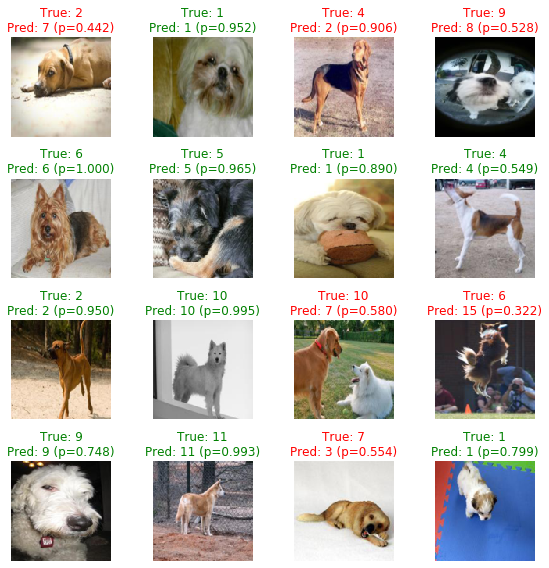

In [32]:
px.random('val')

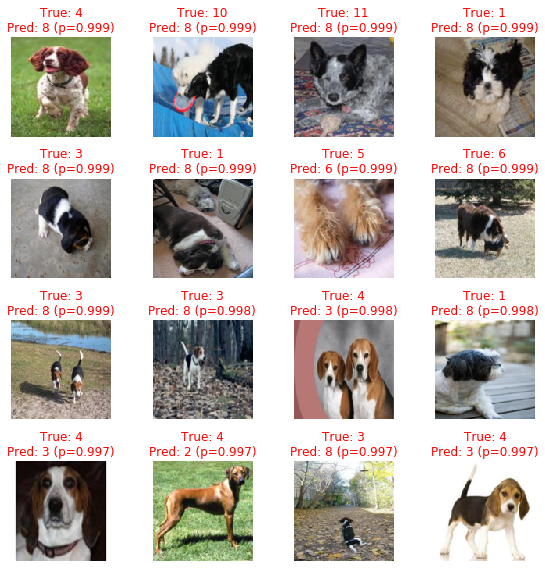

In [33]:
px.most_wrong('val')

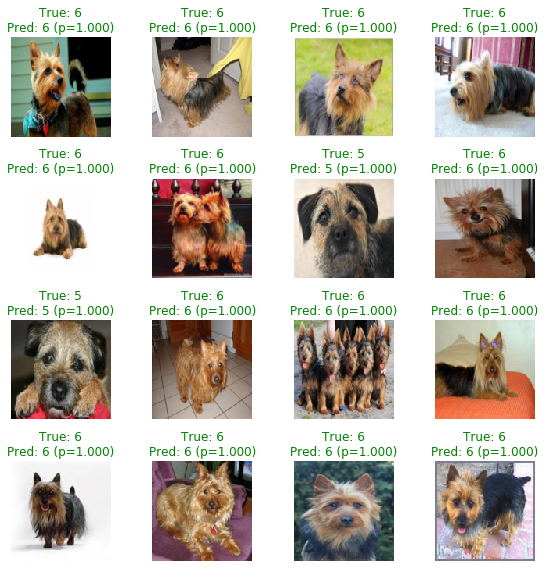

In [34]:
px.most_correct('val')

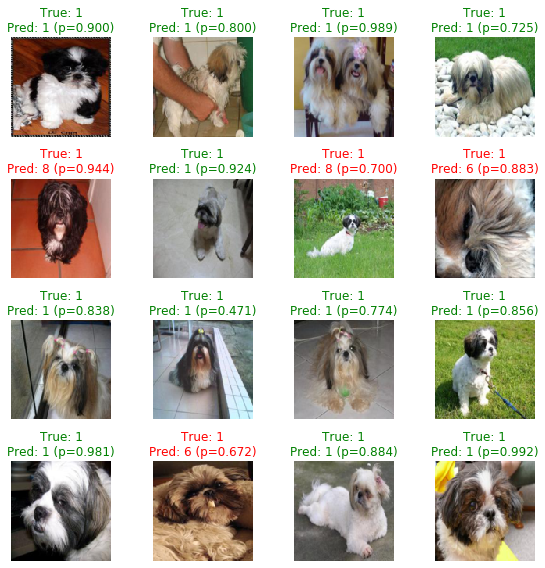

In [35]:
px.random('val', true_classes=[1])